**Configure Devices**

In [1]:
import sys
import tensorflow as tf
sys.path.append('./rcwa_tf/src/')
import tf_utils

In [2]:
# Limit GPU memory growth
tf_utils.config_gpu_memory_usage()

### CHANGE BACK TO GPU:1 WHEN FINISHED

# Choose the device to run on
use_gpu = True
tfDevice = '/job:localhost/replica:0/task:0/device:GPU:1' if use_gpu else '/CPU:0'
print('Executing on device ' + tfDevice + ' ...')

# Measure GPU memory usage
gpu_memory_init = tf_utils.gpu_memory_info()

 
2 Physical GPUs
Executing on device /job:localhost/replica:0/task:0/device:GPU:1 ...


**Dependencies**

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import pdb
import solver
import solver_metasurface
import rcwa_utils
import tensor_utils

**Loss Function Definition**

In [4]:
def focal_spot(params):

    # Generate permittivity and permeability distributions.
    ER_t, UR_t = solver_metasurface.generate_copilot_metasurface_singlelayer(z_var, params)

    # Simulate the system.
    outputs = solver.simulate(ER_t, UR_t, params)

    # First loss term: maximize sum of electric field magnitude within some radius of the desired focal point.
    r = params['focal_spot_radius']
    field = outputs['ty'][:, :, :, np.prod(params['PQ']) // 2, 0]
    focal_plane = solver.propagate(params['input'] * field, params['propagator'], params['upsample'])
    index = (params['pixelsX'] * params['upsample']) // 2
    l1 = tf.math.reduce_sum(tf.abs(focal_plane[0, index-r:index+r, index-r:index+r]))

    # Second loss term: minimize sum of electric field magnitude elsewhere.
    l2 = tf.math.reduce_sum(tf.abs(focal_plane[0, :, :])) - l1

    # First regularization term.
    # Penalize values in z which are far from 1 or params['erd'].
    #r1 = tf.math.reduce_sum( 
    #    (z_var - 1) * (z_var - 1) * (z_var - params['erd']) * (z_var - params['erd']) ).numpy()

    # Final loss: (negative) field intensity at focal point + regularization term.
    return -params['w_l1']*l1 + params['w_l2']*l2 # + params['w_r1']*r1

**Initialize Parameters**

In [5]:
with tf.device(tfDevice):
    
    # Source parameters.
    wavelengths = [632.0] # Wavengths over which to optimize (nm)
    thetas = [0.0] # Polar angles of incident waves over which to optimize
    phis = [0.0] # Azimuthal angles of incident waves over which to optimize
    pte = [1.0] # TE polarization components over which to optimize
    ptm = [0.0] # TM polarization components over which to optimize
    
    # Device parmeters.
    pixelsX = 25 # Number of pixels, i.e. regions of uniform height
    pixelsY = pixelsX
    erd = 6.76 # Relative permittivity of device material
    ers = 2.25 # Relative permittivity of substrate material
    eps_min = 1.0 # Minimum allowed relative permittivity in design
    eps_max = erd # Maximum allowed relative permittivity in design
    L = [632.0, 632.0] # Thicknesses of device layers (0 is substrate) (nm)
    Nlay = len(L) # Number of layers
    Lx = 0.7 * 632.0 # Transverse dimensions of pixels (nm)
    Ly = Lx
    
    # Solver parameters.
    PQ = [5,5] # Number of spatial harmonics in RCWA fourier decomposition
    Nx = 16 # Number transverse direction spatial samples used in simulation, per pixel
    Ny = Nx
    upsample = 11 # Upsampling of simulation used during wave propagation
    
    # Problem parameters.
    N = 2 # Maximum number of optimization iterations
    w_l1 = 1.0 # Weight of first loss term (maximize intensity at center)
    w_l2 = 0.0 # Weight of second loss term (minimize intensity elsewhere)
    w_r1 = 0.0 # Weight of first regularization term (reward permittivity near admissable values)
    thresholding_enabled = True # Enable differentiable thresholding using a sigmoid at each step
    sigmoid_coeff = 1.0 # Parameters for thresholding
    sigmoid_update = 20.0 / N
    learning_rate = 1E-0
    focal_spot_radius = 10 # Size of region in which intensity is maximized
    random_init = False # Enable random initialization of metasurface
    debug = False # Enable debug messages
    
    
    # Initialize and populate dictionary of parameters.
    params = solver.initialize_params(wavelengths=wavelengths, thetas=thetas, phis=phis,
                                      pte=pte, ptm=ptm,
                                      pixelsX=pixelsX, pixelsY=pixelsY,
                                      erd=erd, ers=ers, PQ=PQ,
                                      Lx=Lx, Ly=Ly,
                                      L=L, Nx=Nx,
                                      eps_min=eps_min, eps_max=eps_max)
    
    params['N'] = N
    params['w_l1'] = w_l1
    params['w_l2'] = w_l2
    params['w_r1'] = w_r1
    params['thresholding_enabled'] = thresholding_enabled
    params['sigmoid_coeff'] = sigmoid_coeff
    params['sigmoid_update'] = sigmoid_update
    params['learning_rate'] = learning_rate
    params['focal_spot_radius'] = focal_spot_radius
    params['random_init'] = random_init
    params['debug'] = debug

    # Define the free-space propagator and input field distribution for the metasurface.
    params['f'] = 1.0 * params['Lx'] * params['pixelsX']
    params['upsample'] = upsample
    params['propagator'] = solver.make_propagator(params, params['f'])
    params['input'] = solver.define_input_fields(params)
    
    # Get initial permittivity and permeability profile for the metasurface.
    z_initial = solver_metasurface.init_copilot_metasurface(params)
    z_var = tf.Variable(z_initial, dtype=tf.float32)

**Optimize**

In [6]:
with tf.device(tfDevice):

    # Define an optimizer and data to be stored.
    opt = tf.keras.optimizers.Adam(learning_rate=params['learning_rate'])
    loss = np.zeros(params['N'] + 1)

    # Optimize.
    print('\nOptimizing... Iteration ', end="")
    
    i = 0
    #stopping_condition = 0.00001
    while i < params['N']:
        print(str(i) + ', ', end="")
        
        # Original version, replaced with calls to tape.gradient() and opt.apply_gradients()
        #opt.minimize(focal_spot, var_list = [z_var])
        
        # Calculate gradients.
        with tf.GradientTape() as tape:
            l = focal_spot(params)
            grads = tape.gradient(l, [z_var])
        
        # Apply gradients to variables.
        opt.apply_gradients(zip(grads, [z_var]))
        
        loss[i] = l.numpy()
        
        # Anneal sigmoid coefficient.
        params['sigmoid_coeff'] += params['sigmoid_update']
        
        # Check convergence condition.
        #if (i > 0) and (tf.math.abs((loss[i]/loss[i-1])-1) < stopping_condition):
        #    break
            
        # Increment loop counter.
        i += 1
    
    if (i == N): print('maximum iterations reached.')
    else: print('stopping condition fulfilled.')
        
    # Final sigmoid pass.
    if params['thresholding_enabled']:
        z_var = tf.math.sigmoid(params['sigmoid_coeff'] * (z_var - (1 + (params['erd']-1)/2)) )
        z_var = 1 + (params['erd'] - 1) * z_var
    
    # Final range clip.
    z_var = tf.clip_by_value(z_var, clip_value_min = params['eps_min'], clip_value_max = params['eps_max'])
    
    # Get final loss.
    loss[i] = focal_spot(params).numpy()
    print('Final Loss: ' + str(loss[i]))


Optimizing... Iteration 0, 1, maximum iterations reached.
Final Loss: -375.5624084472656


**Display Learning Curve**

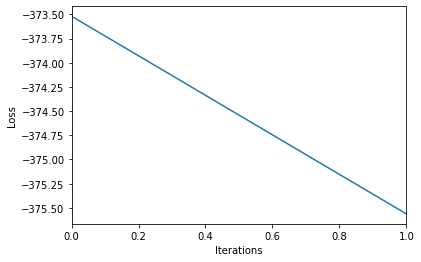

In [7]:
with tf.device(tfDevice):
    
    plt.plot(loss[:i])
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.xlim(0, i-1)
    plt.show()

**Display Resulting Intensity on the Focal Plane**

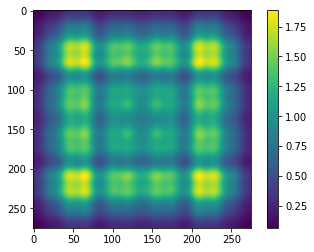

In [8]:
with tf.device(tfDevice):
    
    ER_t, UR_t = solver_metasurface.pixel_to_stacked(z_var, params)
    outputs = solver.simulate(ER_t, UR_t, params)
    field = outputs['ty'][:, :, :, np.prod(params['PQ']) // 2, 0]
    focal_plane = solver.propagate(params['input'] * field, params['propagator'], params['upsample'])
    plt.imshow(tf.abs(focal_plane[0, :, :]) ** 2)
    plt.colorbar()

***Display Resulting Metasurface***

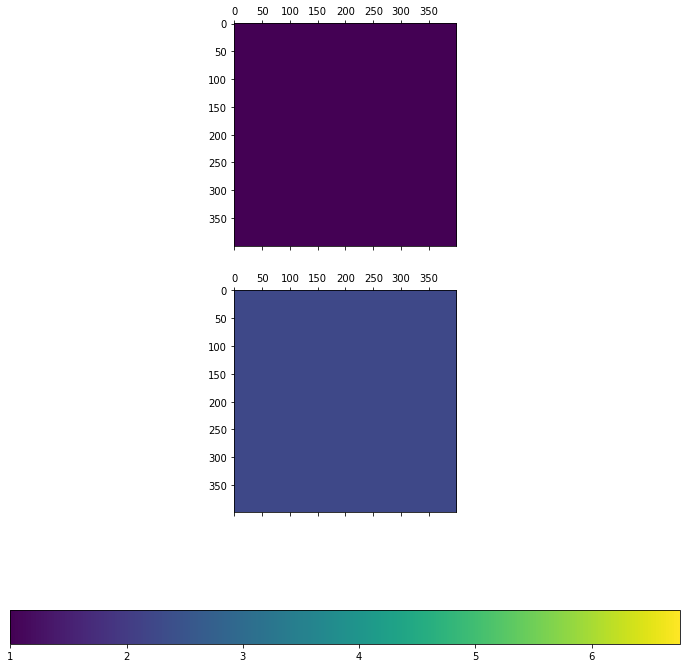

In [9]:
with tf.device(tfDevice):
    
    solver_metasurface.display_metasurface(ER_t, params)

***Check GPU Memory Utilization***

In [10]:
gpu_memory_final = tf_utils.gpu_memory_info()
gpu_memory_used = [gpu_memory_final[1][0] - gpu_memory_init[1][0], gpu_memory_final[1][1] - gpu_memory_init[1][1]]
print('Memory used on each GPU(MiB): ' + str(gpu_memory_used))

Memory used on each GPU(MiB): [8869, 417]
